# artificial neural network

In [1]:
from __future__ import print_function

import csv
import math
import re

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

In [2]:
def is_digit(x):
    if re.match("^-?\d+?\.\d*?$", x) is None:
        return False
    return True

## Colebrook
Data taken from: C.F. Colebrook and C.M. White, "Experiments with Fluid Friction in Roughened Pipes", Proceedings of the Royal Society A, 161, 1937 (https://doi.org/10.1098/rspa.1937.0150).

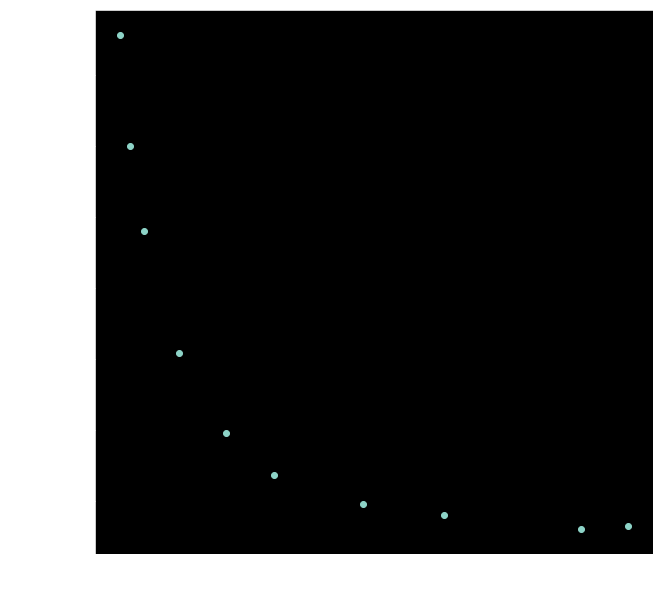

In [3]:
raw = []
with open('pipe.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        if is_digit(row[0]):
            raw.append([float(x) for x in row])
data = np.array(raw)
x_data = data[:,0]
y_data = data[:,1]
plt.figure(figsize=(10,10))
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 14})
plt.plot(x_data, y_data, 'o')
plt.xlabel('Rey')
plt.ylabel(r'$\frac{8\tau}{\rho U^2}$')
plt.show()

In [4]:
pipe_friction_dataframe = pd.read_csv("pipe.csv", sep=",")

In [5]:
def preprocess_features(pipe_friction_dataframe):
  """Prepares input features from Colebrook data set.

  Args:
    pipe_friction_dataframe: A Pandas DataFrame expected to contain data
      from the Colebrook data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = pipe_friction_dataframe[["rey"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["log_rey"] = pipe_friction_dataframe["rey"].apply(math.log)
  return processed_features

def preprocess_targets(pipe_friction_dataframe):
  """Prepares target features (i.e., labels) from Colebrook data set.

  Args:
    pipe_friction_dataframe: A Pandas DataFrame expected to contain data
      from the Colebrook data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of centi
  output_targets["lambda"] = pipe_friction_dataframe["lambda"]*100.0
  return output_targets

In [6]:
# Choose the odd examples for training.
train_set = [0,1,2,4,6,8,9]
training_examples = preprocess_features(pipe_friction_dataframe.take(train_set))
training_targets = preprocess_targets(pipe_friction_dataframe.take(train_set))

# Choose the even examples for validation.
validation_set = [3,5,7]
validation_examples = preprocess_features(pipe_friction_dataframe.take(validation_set))
validation_targets = preprocess_targets(pipe_friction_dataframe.take(validation_set))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,rey,log_rey
count,7.00000,7.00000
mean,51507.14286,10.21876
std,52009.42566,1.32751
min,5100.00000,8.53700
25%,9075.00000,9.09595
50%,30600.00000,10.32876
75%,89750.00000,11.36007
max,127200.00000,11.75352


Validation examples summary:


,rey,log_rey
count,3.00000,3.00000
mean,48100.00000,10.61329
std,32285.13590,0.72990
min,19300.00000,9.86786
25%,30650.00000,10.25664
50%,42000.00000,10.64542
75%,62500.00000,10.98601
max,83000.00000,11.32660


Training targets summary:


,lambda
count,7.00000
mean,4.05429
std,0.71645
min,3.40000
25%,3.45000
50%,3.74000
75%,4.60000
max,5.14000


Validation targets summary:


,lambda
count,3.00000
mean,3.68667
std,0.29704
min,3.45000
25%,3.52000
50%,3.59000
75%,3.80500
max,4.02000


In [7]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [8]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [9]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

def linear_scale_array(array):
  min_val = min(array)
  max_val = max(array)
  scale = (max_val - min_val) / 2.0
  return np.array([((x - min_val) / scale) - 1.0 for x in array])

In [10]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["rey"] = linear_scale(examples_dataframe["rey"])
  processed_features["log_rey"] = linear_scale(examples_dataframe["log_rey"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(pipe_friction_dataframe))
normalized_training_examples = normalized_dataframe.take(train_set)
normalized_validation_examples = normalized_dataframe.take(validation_set)

In [11]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      activation_fn=tf.nn.tanh
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["lambda"], 
                                          batch_size=batch_size,
                                          shuffle=False)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["lambda"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["lambda"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.5f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(10,10))
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.5f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.5f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 0.04415
  period 01 : 0.03369
  period 02 : 0.03094
  period 03 : 0.02946
  period 04 : 0.02838
  period 05 : 0.02783
  period 06 : 0.02743
  period 07 : 0.02711
  period 08 : 0.02681
  period 09 : 0.02636
Model training finished.
Final RMSE (on training data):   0.02636
Final RMSE (on validation data): 0.01338


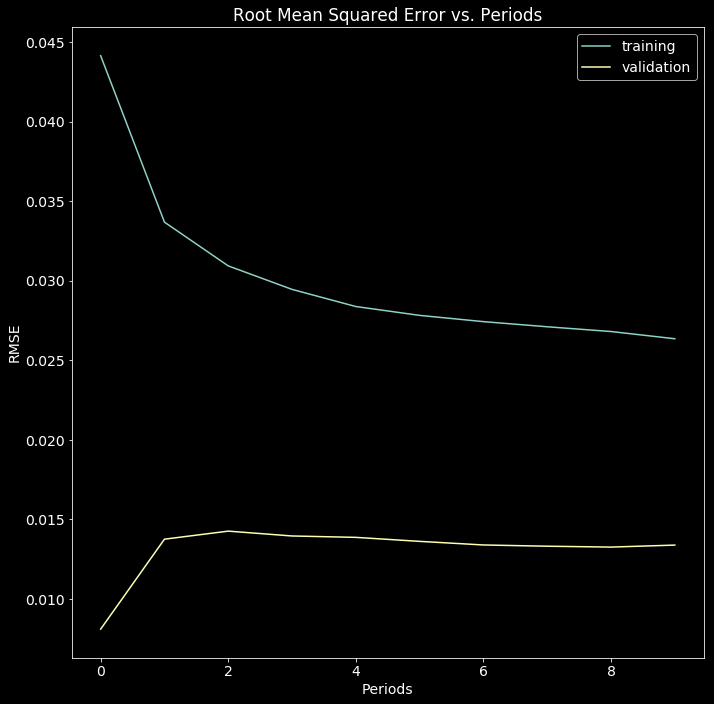

In [12]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.008, l1_regularization_strength=0.01),
    steps=200000,
    batch_size=len(train_set),
    hidden_units=[5, 3],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

In [13]:
nn_regressor = _[0]

In [14]:
rey_plot = np.linspace(x_data[0], x_data[-1], 101)
x_plot = {'rey': linear_scale_array(rey_plot), 'log_rey': linear_scale_array(np.array([math.log(x) for x in rey_plot]))}
predictions = nn_regressor.predict(input_fn=lambda: my_input_fn(x_plot,np.random.rand(101),1,shuffle=False))

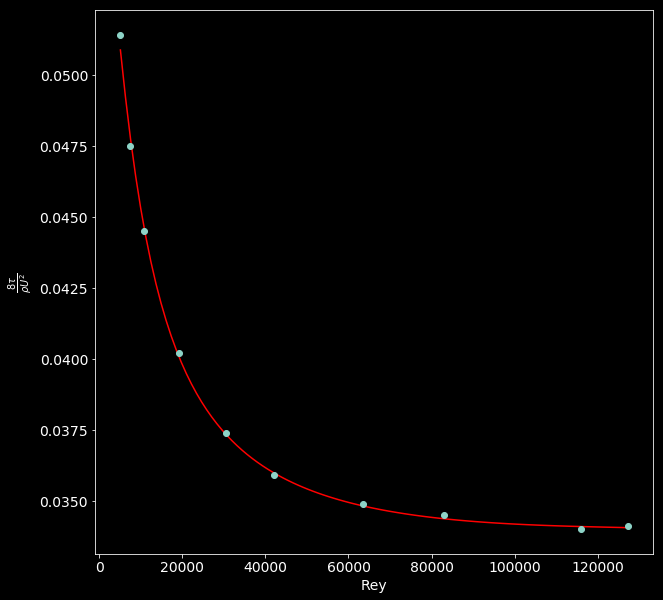

In [15]:
i = 0
y_plot = []
for item in predictions:
    i += 1
    if i > len(x_plot['rey']):
        break
    else:
        y_plot.append(item['predictions'][0])

plt.figure(figsize=(10,10))
plt.plot(rey_plot,[y/100 for y in y_plot],'r', label='ann')
plt.plot(x_data, y_data, 'o', label='experiments')
plt.xlabel('Rey')
plt.ylabel(r'$\frac{8\tau}{\rho U^2}$')
plt.legend()
plt.show()